<a href="https://colab.research.google.com/github/MohamedMadhoun/AdultIncomeClassificationProject/blob/main/Adult_Income_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adult Income Classification Project
Author : Mohammed Al-Madhoun

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

from sklearn.inspection import permutation_importance
from sklearn import set_config
set_config(transform_output='pandas')


In [3]:

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class GroupByImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col, target_col):
        self.group_col = group_col
        self.target_col = target_col
        self.fill_values_ = {}

    def fit(self, X, y=None):
        df = X.copy()
        self.fill_values_ = (
            df.groupby(self.group_col)[self.target_col]
              .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
              .to_dict()
        )
        self.global_mode_ = (
            df[self.target_col].mode().iloc[0]
            if not df[self.target_col].mode().empty
            else pd.NA
        )
        return self

    def transform(self, X):
        df = X.copy()
        def impute(row):
            if pd.isna(row[self.target_col]):
                return self.fill_values_.get(row[self.group_col], self.global_mode_)
            else:
                return row[self.target_col]

        df[self.target_col] = df.apply(impute, axis=1)
        return df[[self.target_col]]

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict


In [5]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
                          color_dict=None, ax=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax

## Loading Data

In [6]:
df = pd.read_csv('/content/drive/MyDrive/AXSOSACADEMY/05-IntermediateML/Week17/Data/adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


## Data Cleaning

How many rows/columns:

In [8]:
df.shape

(48842, 15)

 - There are 48842 rows and 15 columns

Checking the data types:

In [9]:
df.dtypes

,0
age,int64
workclass,object
fnlwgt,int64
education,object
educational-num,int64
marital-status,object
occupation,object
relationship,object
race,object
gender,object


 - All other data types are as they should be.

### Duplicated Data
Checking for duplicated data:

In [10]:
df.duplicated().sum()

np.int64(52)

- There are 52 duplicates in the dataset which we will drop.

In [11]:
df.drop_duplicates(inplace = True)

In [12]:
df.duplicated().sum()

np.int64(0)

- Checking to make sure duplicates were dropped.

In [13]:
df.nunique()

,0
age,74
workclass,9
fnlwgt,28523
education,16
educational-num,16
marital-status,7
occupation,15
relationship,6
race,5
gender,2


In [14]:
for col in df.columns:
    print(f"Unique values in column '{col}':")
    print(df[col].unique())
    print("-" * 20)


Unique values in column 'age':
[25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72 45 22 23 54
 32 46 56 17 39 52 21 42 33 30 47 41 19 69 50 31 59 49 51 27 57 61 64 79
 73 53 77 80 62 35 68 66 75 60 67 71 70 90 81 74 78 82 83 85 76 84 89 88
 87 86]
--------------------
Unique values in column 'workclass':
['Private' 'Local-gov' '?' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
--------------------
Unique values in column 'fnlwgt':
[226802  89814 336951 ... 129912 255835 257302]
--------------------
Unique values in column 'education':
['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool']
--------------------
Unique values in column 'educational-num':
[ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1]
--------------------
Unique values in column 'marital-status':
['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced

In [15]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

df[numeric_columns] = df[numeric_columns].astype(float)

In [16]:
df.replace("?", np.nan, inplace=True)


### Missing Values
Checking for missing values:

In [17]:
df.isna().sum()

,0
age,0
workclass,2795
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,2805
relationship,0
race,0
gender,0


In [18]:
non_useful_columns_for_used_algorithms = ['fnlwgt', 'education']
df_1 = df.copy()
df_1.drop(non_useful_columns_for_used_algorithms, axis=1, inplace=True)

df_1.info()


<class 'pandas.core.frame.DataFrame'>
Index: 48790 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              48790 non-null  float64
 1   workclass        45995 non-null  object 
 2   educational-num  48790 non-null  float64
 3   marital-status   48790 non-null  object 
 4   occupation       45985 non-null  object 
 5   relationship     48790 non-null  object 
 6   race             48790 non-null  object 
 7   gender           48790 non-null  object 
 8   capital-gain     48790 non-null  float64
 9   capital-loss     48790 non-null  float64
 10  hours-per-week   48790 non-null  float64
 11  native-country   47934 non-null  object 
 12  income           48790 non-null  object 
dtypes: float64(5), object(8)
memory usage: 5.2+ MB


In [19]:
df_1.shape


(48790, 13)

In [20]:
df_1.duplicated().sum()


np.int64(6322)

In [21]:
df_1.drop_duplicates(inplace=True)


In [22]:
df_1.isna().sum()

,0
age,0
workclass,2411
educational-num,0
marital-status,0
occupation,2421
relationship,0
race,0
gender,0
capital-gain,0
capital-loss,0


 check the class balance of the dataset before building any model.


In [23]:
df['income'].value_counts(normalize=True)


,proportion
income,
<=50K,0.760586
>50K,0.239414


- The data is imbalanced

## (Exploratory Visualizations)


###  Income Distribution


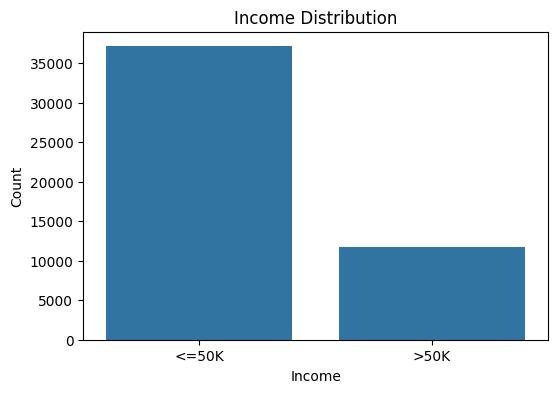

In [24]:
# Distribution of income
plt.figure(figsize=(6, 4))
sns.countplot(x=df["income"])
plt.title("Income Distribution")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()





- This plot shows the distribution of individuals based on their income levels.  
It helps us understand the class balance between `<=50K` and `>50K` income groups, which is essential for model evaluation and handling class imbalance.


### Education Level vs Income

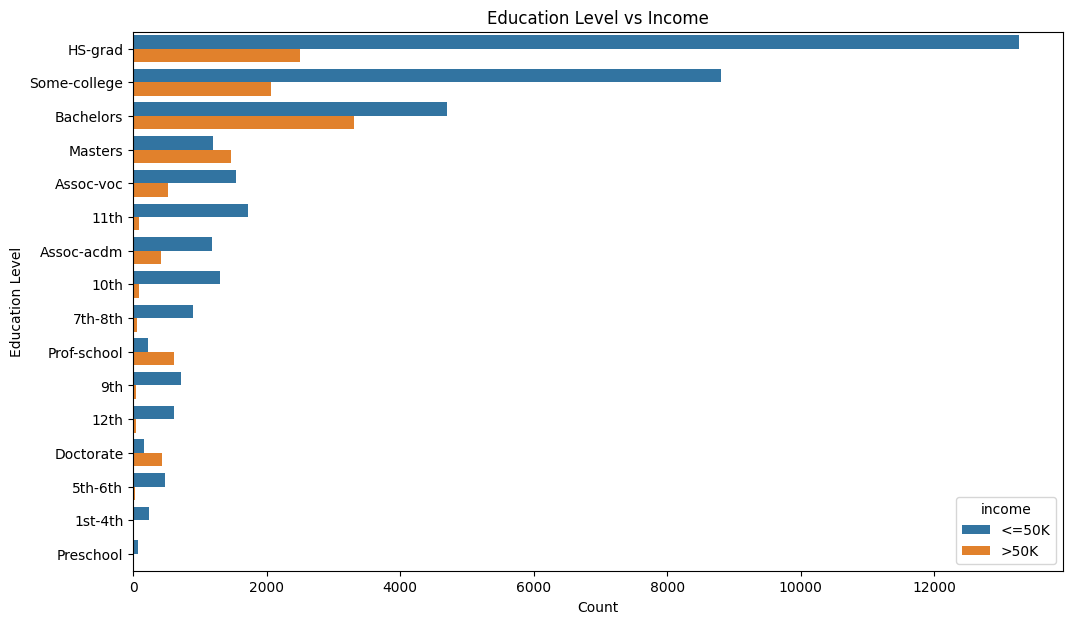

In [25]:
# Education vs Income
plt.figure(figsize=(12, 7))
sns.countplot(y="education", hue="income", data=df, order=df["education"].value_counts().index)
plt.title("Education Level vs Income")
plt.xlabel("Count")
plt.ylabel("Education Level")
plt.show()


- This plot compares income distribution (`<=50K` vs `>50K`) across various education levels.  
It clearly shows that individuals with higher education levels (such as Bachelors, Masters, and Doctorate) are more likely to earn over $50K annually.  
In contrast, those with lower education levels tend to fall in the `<=50K` income group.




###  Gender vs Income


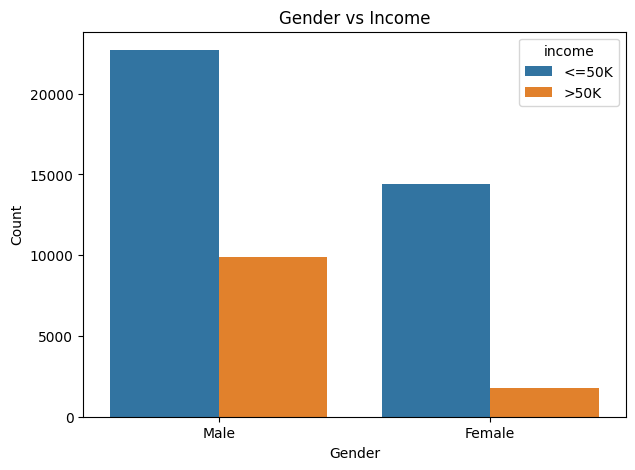

In [26]:
# Gender vs Income
plt.figure(figsize=(7, 5))
sns.countplot(x="gender", hue="income", data=df)
plt.title("Gender vs Income")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


This plot displays the distribution of income levels (`<=50K` vs `>50K`) for both genders.  
It reveals a noticeable gender gap in income: **males are significantly more likely to earn >$50K** compared to females.  



### Age Distribution by Income


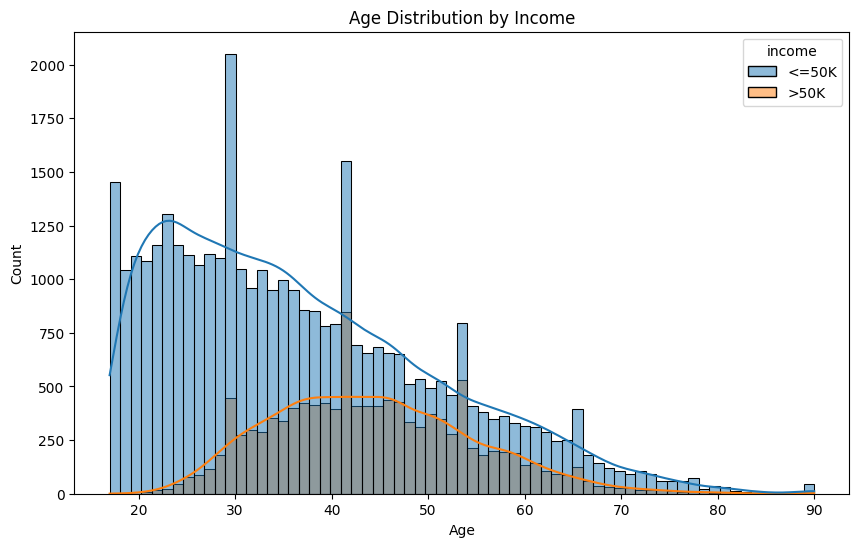

In [27]:
# Age distribution by income
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="age", hue="income", kde=True)
plt.title("Age Distribution by Income")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


This plot shows the age distribution for individuals grouped by income level (`<=50K` vs `>50K`).  
Using a histogram with KDE (Kernel Density Estimate), we can observe age trends for both income groups.

- Younger individuals (under 30) are more likely to earn <=$50K.
- The probability of earning >$50K increases with age, especially between ages 30 and 50.
- After age 60, the number of high earners drops in both groups.


#  Building the Classification Model


###  Encoding Income Column
To prepare the target variable for machine learning algorithms, we convert the categorical `income` column into numerical format:

- `<=50K` → 0  
- `>50K` → 1  

This binary encoding is essential for classification models to interpret the target properly.



In [28]:
df_1['income'] = df_1['income'].map({'<=50K': 0, '>50K': 1})


In [29]:
X = df_1.drop(columns=['income'])
y = df_1['income']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [30]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)



Numeric columns: ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


In [31]:
from sklearn.impute import SimpleImputer

workclass_imputer = SimpleImputer(strategy='most_frequent')
X_train['workclass'] = workclass_imputer.fit_transform(X_train[['workclass']])
X_test['workclass'] = workclass_imputer.transform(X_test[['workclass']])

occ_imputer = GroupByImputer(group_col='workclass', target_col='occupation')
X_train['occupation'] = occ_imputer.fit_transform(X_train)
X_test['occupation'] = occ_imputer.transform(X_test)

country_imputer = SimpleImputer(strategy='most_frequent')
X_train['native-country'] = country_imputer.fit_transform(X_train[['native-country']])
X_test['native-country'] = country_imputer.transform(X_test[['native-country']])




In [32]:
numeric_cols = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = ['marital-status', 'relationship', 'race', 'gender', 'workclass', 'occupation', 'native-country']


In [33]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def create_preprocessor(use_drop_first=False):
    drop_value = 'first' if use_drop_first else None

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop=drop_value), categorical_cols)
    ])

    return preprocessor



----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     25616
           1       0.98      0.99      0.99     25616

    accuracy                           0.99     51232
   macro avg       0.99      0.99      0.99     51232
weighted avg       0.99      0.99      0.99     51232



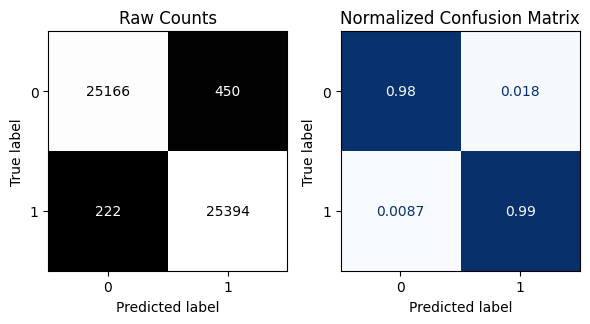


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6404
           1       0.63      0.64      0.64      2090

    accuracy                           0.82      8494
   macro avg       0.76      0.76      0.76      8494
weighted avg       0.82      0.82      0.82      8494



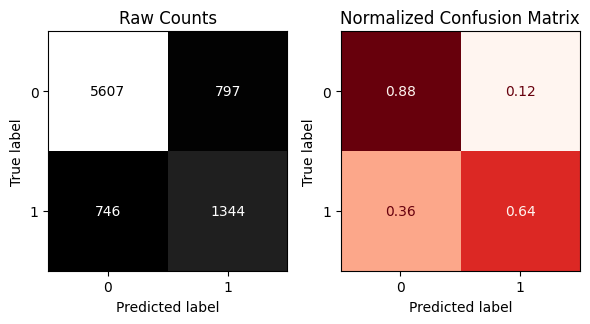

In [34]:
preprocessor = create_preprocessor(use_drop_first=False)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

# Get column names
encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numeric_cols) + list(encoded_cols)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_prep, y_train)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
evaluate_classification(rf, X_train_res, y_train_res, X_test_prep, y_test)



- We trained a Random Forest Classifier to predict income levels.  
While it achieved **high accuracy on the training set**, the performance on the test set was significantly lower — a clear sign of **overfitting**.


# Feature Importance Analysis using Permutation Importance

After training the Random Forest model, we calculated feature importances using Permutation Importance. This method measures how much the model's performance decreases when the values of a feature are randomly shuffled. Features that cause the biggest drop in performance are considered most important.

The plot below shows the top 10 most important features.


/tmp/ipython-input-35-1082434047.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[:10], y=importances[:10].index, palette="viridis")


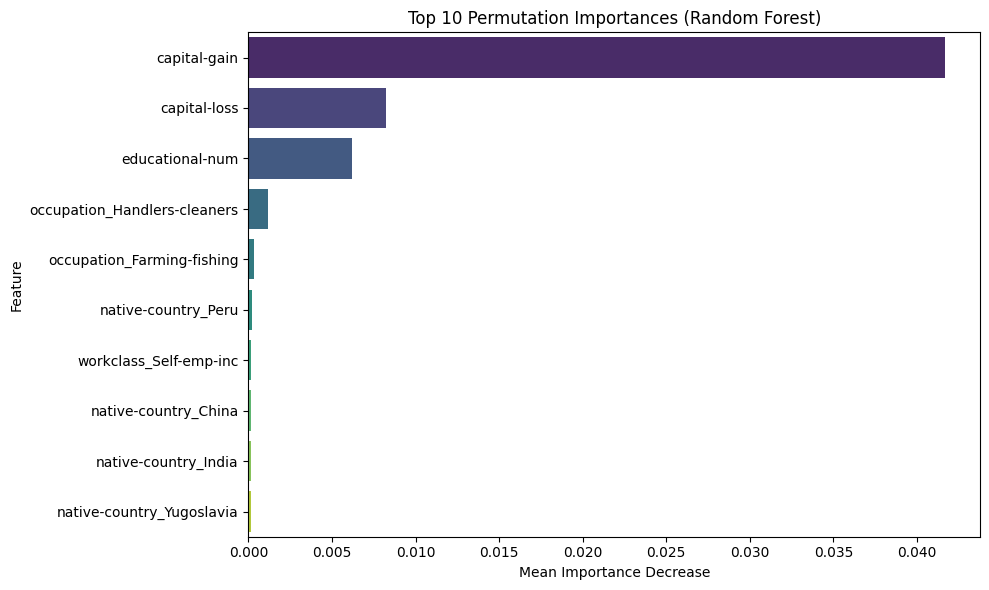

In [35]:
# Calculate Permutation Importance on X_test_prep
result = permutation_importance(
    rf, X_test_prep, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Sorting results in a DataFrame
importances = pd.Series(result.importances_mean, index=all_feature_names).sort_values(ascending=False)

# Draw the most important features (top 10)
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[:10], y=importances[:10].index, palette="viridis")
plt.title("Top 10 Permutation Importances (Random Forest)")
plt.xlabel("Mean Importance Decrease")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [36]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=3, random_state=42)
X_train_pca = pca.fit_transform(X_train_prep)
X_test_pca = pca.transform(X_test_prep)

X_train_combined = np.hstack([X_train_prep, X_train_pca])
X_test_combined = np.hstack([X_test_prep, X_test_pca])


In [38]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(RandomForestClassifier(random_state=42), threshold="median")
X_train_selected = selector.fit_transform(X_train_combined, y_train)
X_test_selected = selector.transform(X_test_combined)


In [39]:
smote = SMOTE(random_state=42)
X_train_selected_res, y_train_selected_res = smote.fit_resample(X_train_selected, y_train)


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     25616
           1       0.98      0.99      0.99     25616

    accuracy                           0.99     51232
   macro avg       0.99      0.99      0.99     51232
weighted avg       0.99      0.99      0.99     51232



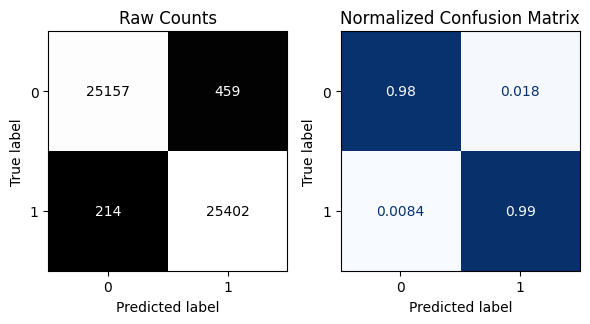


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      6404
           1       0.62      0.68      0.65      2090

    accuracy                           0.82      8494
   macro avg       0.76      0.77      0.76      8494
weighted avg       0.83      0.82      0.82      8494



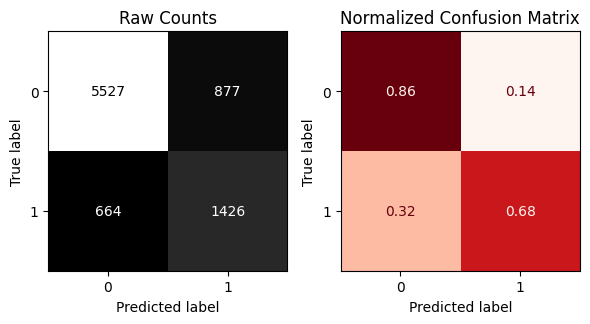

In [40]:
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected_res, y_train_selected_res)

evaluate_classification(rf_selected, X_train_selected_res, y_train_selected_res, X_test_selected, y_test)


/tmp/ipython-input-42-1582586182.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_named.values, y=top_10_named.index, palette="magma")


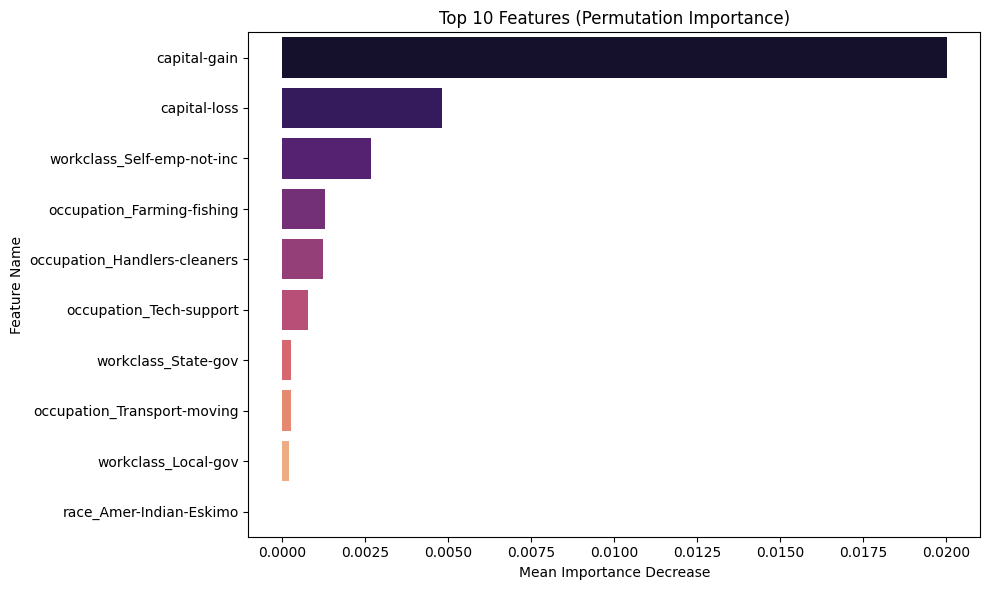

In [42]:
pca_feature_names = ['PCA_1', 'PCA_2', 'PCA_3']
all_combined_feature_names = all_feature_names + pca_feature_names
# This returns a boolean mask for the selected features.
selected_mask = selector.get_support()

# We use the mask to extract the names.
selected_feature_names = np.array(all_combined_feature_names)[selected_mask]
# Use actual feature names instead of numbers.
importances_named = pd.Series(result.importances_mean, index=selected_feature_names)
top_10_named = importances_named.sort_values(ascending=False)[:10]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_named.values, y=top_10_named.index, palette="magma")
plt.title("Top 10 Features (Permutation Importance)")
plt.xlabel("Mean Importance Decrease")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()
